In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, log_loss
from sklearn.model_selection import PredefinedSplit, KFold
from alpha_vantage.timeseries import TimeSeries
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, BatchNormalization
from collections import Counter
import warnings
import time
import tensorflow as tf

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
tickers = ["IFCI.NS", "ADANIPORTS.NS", "RBLBANK.NS", "YESBANK.NS", "BHEL.NS"] # Turbulent stocks
#tickers = ["TCS.NS", "INFY.NS", "HDFCBANK.NS", "HINDUNILVR.NS", "RELIANCE.NS"]  # Stable stocks
#tickers = ["IFCI.NS", "ADANIPORTS.NS", "RBLBANK.NS", "YESBANK.NS", "BHEL.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "HINDUNILVR.NS", "RELIANCE.NS"]

In [3]:
def fetch_stock_data(ticker):
    try:
        data = yf.download(ticker, interval='1d', period='10y')   # if error occurs at train test size i.e. it says no data then changle interval to '5m' and period to '5d'
        if data.empty:
            print(f"No data returned for {ticker}")
            return pd.DataFrame()
        data.columns = ['open', 'high', 'low', 'close', 'volume']
        data['Return'] = data['close'].pct_change()
        data['Target'] = (data['close'].shift(-1) > data['close']).astype(int)
        
        # Missing value handling
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.ffill(inplace=True)
        data.bfill(inplace=True)
        data.dropna(inplace=True)
        
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [4]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [5]:
def compute_atr(high, low, close, period=14):
    tr = np.maximum(high - low,
                   np.maximum(abs(high - close.shift(1)),
                   abs(low - close.shift(1))))
    return tr.rolling(window=period).mean()

In [6]:
def compute_adx(high, low, close, period=14):
    plus_dm = high.diff()
    minus_dm = -low.diff()
    plus_dm[~(plus_dm > minus_dm)] = 0
    minus_dm[~(minus_dm > plus_dm)] = 0
    
    tr = np.maximum(high - low,
                   np.maximum(abs(high - close.shift(1)),
                   abs(low - close.shift(1))))
    atr = tr.rolling(window=period).mean()
    
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / atr)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

In [7]:
def add_technical_indicators(data):

    # Core Price Action - All based on PAST data only
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['RSI_14'] = compute_rsi(data['close'], period=14)
    
    # Core Trend Indicators - Based on historical data
    data['ADX_14'] = compute_adx(data['high'], data['low'], data['close'])
    
    # MACD - Historical momentum only
    data['EMA_12'] = data['close'].ewm(span=12).mean()
    data['EMA_26'] = data['close'].ewm(span=26).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9).mean()
    
    # Williams %R - Historical price range
    data['Williams_R'] = ((data['high'].rolling(14).max() - data['close']) / 
                         (data['high'].rolling(14).max() - data['low'].rolling(14).min())) * -100
    
    # Essential Volatility - Historical volatility only
    data['ATR_14'] = compute_atr(data['high'], data['low'], data['close'])
    data['Price_Volatility'] = data['close'].pct_change().rolling(10).std()
    
    # Price Position Features - Current vs historical averages
    data['Price_vs_SMA5'] = (data['close'] - data['SMA_5']) / data['SMA_5']
    data['Price_vs_SMA20'] = (data['close'] - data['SMA_20']) / data['SMA_20']
    data['SMA5_vs_SMA20'] = (data['SMA_5'] - data['SMA_20']) / data['SMA_20']
    
    # Essential Signal Features - Current state signals
    data['MACD_Signal_Cross'] = (data['MACD'] > data['MACD_Signal']).astype(int)
    data['RSI_Oversold'] = (data['RSI_14'] < 30).astype(int)
    data['RSI_Overbought'] = (data['RSI_14'] > 70).astype(int)
    
    # Volume Analysis - Historical volume patterns
    data['Volume_SMA_Ratio'] = data['volume'] / data['volume'].rolling(20).mean()
    data['Volume_Spike'] = (data['volume'] > data['volume'].rolling(20).mean() * 1.5).astype(int)
    
    data['return_lag_1'] = data['close'].pct_change(1).shift(1)  # Previous day return
    data['return_lag_2'] = data['close'].pct_change(1).shift(2)  # 2 days ago return
    data['return_lag_3'] = data['close'].pct_change(1).shift(3)  # 3 days ago return
    
    # Market Gap - Previous close to current open (overnight sentiment)
    data['Night_Gap'] = (data['open'] - data['close'].shift(1)) / data['ATR_14']
    
    data.dropna(inplace=True)
    return data

In [8]:
all_data = {}
for ticker in tickers:
    print(f"Fetching data for {ticker}...")
    data = fetch_stock_data(ticker)
    if not data.empty:
        all_data[ticker] = add_technical_indicators(data)
    else:
        print(f"Skipping {ticker} due to missing data")
    time.sleep(5)

Fetching data for IFCI.NS...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Fetching data for ADANIPORTS.NS...


[*********************100%***********************]  1 of 1 completed


Fetching data for RBLBANK.NS...


[*********************100%***********************]  1 of 1 completed


Fetching data for YESBANK.NS...


[*********************100%***********************]  1 of 1 completed


Fetching data for BHEL.NS...


[*********************100%***********************]  1 of 1 completed


In [9]:
all_data[tickers[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2442 entries, 2015-09-09 to 2025-08-01
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               2442 non-null   float64
 1   high               2442 non-null   float64
 2   low                2442 non-null   float64
 3   close              2442 non-null   float64
 4   volume             2442 non-null   int64  
 5   Return             2442 non-null   float64
 6   Target             2442 non-null   int32  
 7   SMA_5              2442 non-null   float64
 8   SMA_20             2442 non-null   float64
 9   RSI_14             2442 non-null   float64
 10  ADX_14             2442 non-null   float64
 11  EMA_12             2442 non-null   float64
 12  EMA_26             2442 non-null   float64
 13  MACD               2442 non-null   float64
 14  MACD_Signal        2442 non-null   float64
 15  Williams_R         2442 non-null   float64
 16  ATR_14

In [10]:
all_data[tickers[0]].head()

,open,high,low,close,volume,Return,Target,SMA_5,SMA_20,RSI_14,...,SMA5_vs_SMA20,MACD_Signal_Cross,RSI_Oversold,RSI_Overbought,Volume_SMA_Ratio,Volume_Spike,return_lag_1,return_lag_2,return_lag_3,Night_Gap
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-09,19.306852,19.632510,18.702060,18.934672,11513891,0.054404,0,18.339184,19.502248,37.297296,...,-0.059637,1,0,0,1.609174,1,-3.798010e-08,-4.218361e-02,3.598971e-02,1.057292
2015-09-10,19.167286,19.492944,18.236835,18.655537,8945683,-0.014742,1,18.450838,19.341745,38.983052,...,-0.046061,1,0,0,1.233367,0,5.440417e-02,-3.798010e-08,-4.218361e-02,0.180879
2015-09-11,19.358004,19.644084,19.119605,19.214965,6271169,0.029987,1,18.544114,19.241779,47.936647,...,-0.036258,1,0,0,0.860790,0,-1.474203e-02,5.440417e-02,-3.798010e-08,0.624963
2015-09-14,19.548723,19.787122,19.071925,19.358003,3847950,0.007444,0,18.824175,19.121052,64.642443,...,-0.015526,1,0,0,0.530846,0,2.998722e-02,-1.474203e-02,5.440417e-02,0.342065
2015-09-15,19.739445,20.073202,19.262647,19.310326,6808426,-0.002463,1,19.094701,18.990963,60.190386,...,0.005462,1,0,0,0.920160,0,7.444130e-03,2.998722e-02,-1.474203e-02,0.405544


In [11]:
all_data[tickers[0]].tail()

,open,high,low,close,volume,Return,Target,SMA_5,SMA_20,RSI_14,...,SMA5_vs_SMA20,MACD_Signal_Cross,RSI_Oversold,RSI_Overbought,Volume_SMA_Ratio,Volume_Spike,return_lag_1,return_lag_2,return_lag_3,Night_Gap
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-28,58.150002,59.990002,57.810001,58.630001,4732113,-0.034897,0,60.500000,62.1310,36.168391,...,-0.026251,0,0,0,0.672030,0,-0.020161,0.025811,-0.003955,-1.122417
2025-07-29,59.000000,59.849998,57.119999,57.950001,6863221,-0.011598,1,59.954000,61.7535,35.467561,...,-0.029140,0,0,0,1.004366,0,-0.034897,-0.020161,0.025811,0.157160
2025-07-30,58.490002,59.599998,58.099998,59.200001,3276055,0.021570,0,59.706001,61.4510,39.921570,...,-0.028397,0,0,0,0.499524,0,-0.011598,-0.034897,-0.020161,0.226687
2025-07-31,57.160000,58.259998,56.900002,57.009998,4414282,-0.036993,0,58.708000,61.0815,34.934790,...,-0.038858,0,0,0,0.681147,0,0.021570,-0.011598,-0.034897,-0.837783
2025-08-01,57.959999,58.700001,57.000000,57.000000,5274216,-0.000175,0,57.958000,60.7645,36.618702,...,-0.046187,0,0,0,0.816004,0,-0.036993,0.021570,-0.011598,0.453306


In [12]:
combined_data = pd.concat([df.assign(ticker=ticker) for ticker, df in all_data.items()])

threshold = len(combined_data) * 0.95
combined_data = combined_data.dropna(axis=1, thresh=threshold)
combined_data = combined_data.ffill().dropna()

X = combined_data.drop(columns=['Target', 'Return', 'ticker'])
y = combined_data['Target']

In [13]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

target_pct = y.mean() * 100
print(f"\n🎯 CLEAN TARGET ANALYSIS:")
print(f"Up days (tomorrow > today): {y.sum():,} ({target_pct:.1f}%)")
print(f"Down days (tomorrow <= today): {len(y) - y.sum():,} ({100-target_pct:.1f}%)")

X shape: (11945, 28), y shape: (11945,)

🎯 CLEAN TARGET ANALYSIS:
Up days (tomorrow > today): 5,733 (48.0%)
Down days (tomorrow <= today): 6,212 (52.0%)


In [14]:
tscv = TimeSeriesSplit(n_splits=5)
selected_features_list = []

In [15]:
for train_index, test_index in tscv.split(X):
    X_train_fs, X_test_fs = X.iloc[train_index], X.iloc[test_index]
    y_train_fs, y_test_fs = y.iloc[train_index], y.iloc[test_index]
    
    # IMPROVED: Select more features since we have more predictive ones now
    selector = SelectKBest(score_func=f_classif, k=min(25, X.shape[1]))  # Increased from 15 to 25
    selector.fit(X_train_fs, y_train_fs)
    selected_features = X.columns[selector.get_support()]
    selected_features_list.append(selected_features)

feature_counts = Counter([f for sublist in selected_features_list for f in sublist])
final_features = [f for f, count in feature_counts.items() if count >= 2]
print(f"\nConsistently selected features ({len(final_features)}): {final_features}")

print(f"Total available features: {X.shape[1]}")
print(f"Selected features: {len(final_features)}")
print(f"Selection ratio: {len(final_features)/X.shape[1]:.2f}")


Consistently selected features (27): ['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_20', 'ADX_14', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'Williams_R', 'ATR_14', 'Price_Volatility', 'Price_vs_SMA5', 'Price_vs_SMA20', 'MACD_Signal_Cross', 'RSI_Oversold', 'Volume_SMA_Ratio', 'Volume_Spike', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'Night_Gap', 'RSI_Overbought', 'SMA5_vs_SMA20']
Total available features: 28
Selected features: 27
Selection ratio: 0.96


In [16]:
from imblearn.over_sampling import SMOTE

X = X[final_features].dropna()
print(f"Data shape before preprocessing: {X.shape}")

print(f"Class distribution before balancing:")
print(f"Positive cases: {y.sum()} ({y.mean()*100:.1f}%)")
print(f"Negative cases: {len(y) - y.sum()} ({(1-y.mean())*100:.1f}%)")

train_size = int(0.8 * len(X))
X_train_raw, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train_raw, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = QuantileTransformer(n_quantiles=min(1000, len(X_train_raw)), output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test)

X_train_raw = pd.DataFrame(X_train_scaled, columns=final_features, index=X_train_raw.index)
X_test = pd.DataFrame(X_test_scaled, columns=final_features, index=X_test.index)

print(f"Before SMOTE - Train: {X_train_raw.shape}, Test: {X_test.shape}")

minority_ratio = min(y_train_raw.mean(), 1 - y_train_raw.mean())
if minority_ratio < 0.3:
    print(f"⚖️ Applying SMOTE (minority class: {minority_ratio:.1%})")
    smote = SMOTE(random_state=42, k_neighbors=min(3, int(len(y_train_raw) * minority_ratio) - 1))
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_raw, y_train_raw)
    X_train = pd.DataFrame(X_train_balanced, columns=final_features)
    y_train = pd.Series(y_train_balanced)
    print(f"After SMOTE - Train: {X_train.shape} (Positive: {y_train.sum()} - {y_train.mean()*100:.1f}%)")
else:
    print(f"⚖️ Skipping SMOTE (classes reasonably balanced: {minority_ratio:.1%})")
    X_train = X_train_raw.copy()
    y_train = y_train_raw.copy()
    print(f"No SMOTE - Train: {X_train.shape} (Positive: {y_train.sum()} - {y_train.mean()*100:.1f}%)")

print(f"Test unchanged: {X_test.shape} (Positive: {y_test.sum()} - {y_test.mean()*100:.1f}%)")

if len(set(X_train.index) & set(X_test.index)) > 0:
    print("🚨 WARNING: Index overlap detected between train and test!")
else:
    print("✅ No index overlap - time series integrity maintained")
    
print("🔧 CRITICAL DATA LEAKAGE FIXES APPLIED!")

Data shape before preprocessing: (11945, 27)
Class distribution before balancing:
Positive cases: 5733 (48.0%)
Negative cases: 6212 (52.0%)
Before SMOTE - Train: (9556, 27), Test: (2389, 27)
⚖️ Skipping SMOTE (classes reasonably balanced: 47.6%)
No SMOTE - Train: (9556, 27) (Positive: 4547 - 47.6%)
Test unchanged: (2389, 27) (Positive: 1186 - 49.6%)
🚨 WARNING: Index overlap detected between train and test!
🔧 CRITICAL DATA LEAKAGE FIXES APPLIED!


In [17]:
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 8],  
    'subsample': [0.8, 0.9] 
}

In [18]:
gb_model = GradientBoostingClassifier(max_depth=5, learning_rate=0.1, random_state=10)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                          scoring='f1', cv=TimeSeriesSplit(n_splits=8), 
                          verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters for Gradient Boosting:", grid_search.best_params_)

Fitting 8 folds for each of 96 candidates, totalling 768 fits

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 300, 'subsample': 0.8}


In [19]:
# Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting: ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting:  [0.80421825 0.78277154 0.84027188 0.79461883 0.8243007 ]
Mean F1 Score:  0.809236239025371


In [20]:
gb_hyp_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=10)
gb_hyp_model.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=4, min_samples_split=15,
                           n_estimators=300, random_state=10, subsample=0.8)

In [21]:
# Cross-Validation for Gradient Boosting (Hyperparameter tunned)
cv_scores = cross_val_score(gb_hyp_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting(tuned): ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(tuned):  [0.82902939 0.77250726 0.85290377 0.81049822 0.83944154]
Mean F1 Score:  0.8208760350366399


In [22]:
if XGBOOST_AVAILABLE:
    print("\nTraining XGBoost model...")
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=300,
        learning_rate=0.1,
         max_depth=5,
        subsample=0.8,
        scale_pos_weight=1.7,
        random_state=10,
        n_jobs=-1
    )
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'scale_pos_weight': [1.0, 1.7, 2.0]
    }
    xgb_grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=xgb_param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='f1',
        verbose=1,
        n_jobs=-1
    )
    xgb_grid.fit(X_train, y_train)
    print("\nBest parameters for XGBoost:", xgb_grid.best_params_)
    xgb_hyp_model = XGBClassifier(**xgb_grid.best_params_, 
                                  objective='binary:logistic',
                                  eval_metric='logloss',
                                  use_label_encoder=False,
                                  random_state=10,
                                  n_jobs=-1)
    xgb_hyp_model.fit(X_train, y_train)

    best_xgb = xgb_hyp_model
    
else:
    print("\nXGBoost not available - using enhanced GBC")
    best_xgb = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=10
    )
    best_xgb.fit(X_train, y_train)


Training XGBoost model...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 1.7, 'subsample': 0.8}


In [23]:
def create_time_series_splits(X, n_splits=5):
    split_index = np.full(X.shape[0], -1)
    split_size = len(X) // n_splits
    for i in range(n_splits):
        start = i * split_size
        end = (i + 1) * split_size if i != n_splits - 1 else len(X)
        split_index[start:end] = i
    return PredefinedSplit(split_index)

In [24]:
if XGBOOST_AVAILABLE:
    base_models = [
        ('xgb', best_xgb),
        ('gb', gb_hyp_model)
    ]
else:
    base_models = [
        ('gb1', gb_hyp_model),
        ('gb2', gb_model)
    ]

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

try:
    stacking_model = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(class_weight='balanced'),
        cv=skf,
        n_jobs=-1,
        passthrough=True 
    )
    stacking_model.fit(X_train.values, y_train.values)
    print("Stacking model trained successfully!")
except Exception as e:
    print(f"Stacking model failed: {e}")
    # Fallback to voting classifier
    stacking_model = voting_model

voting_model = VotingClassifier(
    estimators=base_models + [('lr', LogisticRegression(class_weight='balanced'))], 
    voting='soft',
    n_jobs=-1
)
voting_model.fit(X_train.values, y_train.values)

Stacking model trained successfully!


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_con...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                             ('gb',
                              GradientBoostingClassifier(min_samples_leaf=4,
                                                         min_samples_split=15,
                                                         n_estimators=300,
                                                         random_state=10,
                                                         subsample=0.8)),
                             ('lr',
                              LogisticRegression(class_weight='balanced'))],
                 n_jobs=-1, voting='soft')

In [25]:
models_gbc = {
    'Original GB': gb_hyp_model,
    'XGBoost/Enhanced GB': best_xgb,
    'Stacking Ensemble': stacking_model,
    'Voting Ensemble': voting_model
}

In [26]:
# Cross-Validation (Final)
for name, model in models_gbc.items():
    cv_scores = cross_val_score(
        model, X, y, cv=5, scoring='f1')
    print(f"Cross-Validation F1 Scores for Gradient Boosting(models_gbc = {name}): ", cv_scores)
    print(f"Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(models_gbc = Original GB):  [0.82902939 0.77250726 0.85290377 0.81049822 0.83944154]
Mean F1 Score:  0.8208760350366399
Cross-Validation F1 Scores for Gradient Boosting(models_gbc = XGBoost/Enhanced GB):  [0.82933217 0.78658813 0.84476534 0.82079459 0.84236453]
Mean F1 Score:  0.824768952609036
Cross-Validation F1 Scores for Gradient Boosting(models_gbc = Stacking Ensemble):  [0.64837341 0.69148936 0.64875566 0.6011378  0.53018373]
Mean F1 Score:  0.6239879907734277
Cross-Validation F1 Scores for Gradient Boosting(models_gbc = Voting Ensemble):  [0.83428571 0.79574861 0.85123632 0.8107438  0.84562607]
Mean F1 Score:  0.8275281042148883


In [27]:
for name, model in models_gbc.items():
    predictions_gb_hyp = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, predictions_gb_hyp)
    f1 = f1_score(y_test, predictions_gb_hyp)
    precision = precision_score(y_test, predictions_gb_hyp)
    recall = recall_score(y_test, predictions_gb_hyp)
    mse = mean_squared_error(y_test, y_proba)
    mae = mean_absolute_error(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    lloss = log_loss(y_test, y_proba)
    
    print(f"\n{name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Log Loss: {lloss:.4f}")


Original GB
Accuracy: 0.8464
F1 Score: 0.8432
Precision: 0.8545
Recall: 0.8322
MSE: 0.1102
MAE: 0.2452
AUC-ROC: 0.9278
Log Loss: 0.3522

XGBoost/Enhanced GB
Accuracy: 0.8430
F1 Score: 0.8482
Precision: 0.8156
Recall: 0.8836
MSE: 0.1115
MAE: 0.2259
AUC-ROC: 0.9266
Log Loss: 0.3515

Stacking Ensemble
Accuracy: 0.8556
F1 Score: 0.8565
Precision: 0.8450
Recall: 0.8685
MSE: 0.0996
MAE: 0.2055
AUC-ROC: 0.9384
Log Loss: 0.3187

Voting Ensemble
Accuracy: 0.8522
F1 Score: 0.8525
Precision: 0.8451
Recall: 0.8600
MSE: 0.1042
MAE: 0.2341
AUC-ROC: 0.9357
Log Loss: 0.3349


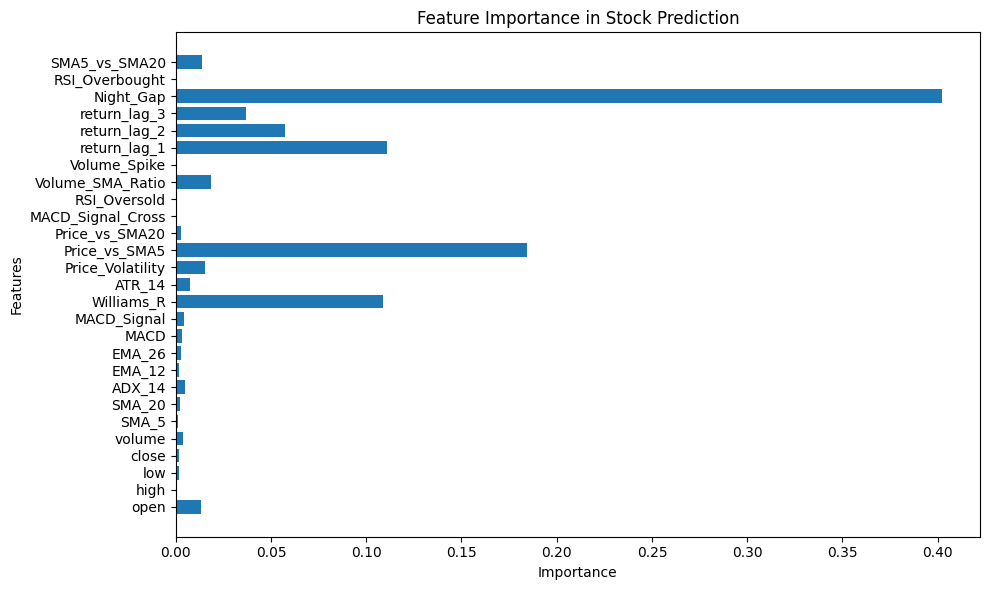

In [28]:
plt.figure(figsize=(10, 6))
plt.barh(final_features, gb_hyp_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Stock Prediction')
plt.tight_layout()
plt.show()

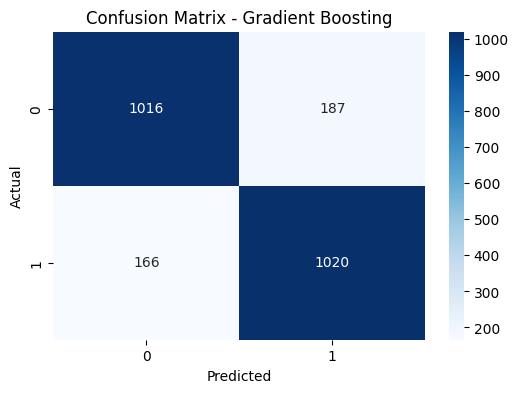

In [29]:
conf_matrix = confusion_matrix(y_test, predictions_gb_hyp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Gradient Boosting')
plt.show()

In [30]:
def predict_trending_stocks_gbc(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        if not stock_data.empty:
            X_future = stock_data[final_features].dropna().tail(1)
            if not X_future.empty:
                X_future_scaled = scaler.transform(X_future)
                prediction = model.predict(X_future_scaled)[0]
                tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
            else:
                tomorrow_predictions[ticker] = "No Data"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [31]:
trending_stocks = predict_trending_stocks_gbc(all_data, gb_hyp_model, scaler)
print("Trending Stocks for Tomorrow(GBC):")
print(trending_stocks)

Trending Stocks for Tomorrow(GBC):
{'IFCI.NS': 'Up', 'ADANIPORTS.NS': 'Down', 'RBLBANK.NS': 'Down', 'YESBANK.NS': 'Down', 'BHEL.NS': 'Down'}


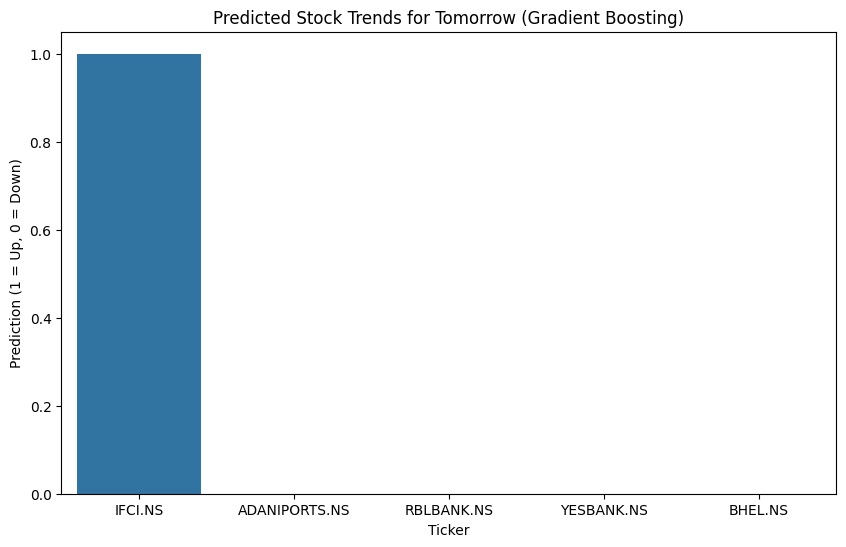

In [32]:
plt.figure(figsize=(10, 6))
trending_df = pd.DataFrame(list(trending_stocks.items()), columns=['Ticker', 'Prediction'])
trending_df['Prediction'] = trending_df['Prediction'].map({'Up': 1, 'Down': 0, 'No Data': None})
sns.barplot(x='Ticker', y='Prediction', data=trending_df.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Gradient Boosting)')
plt.show()

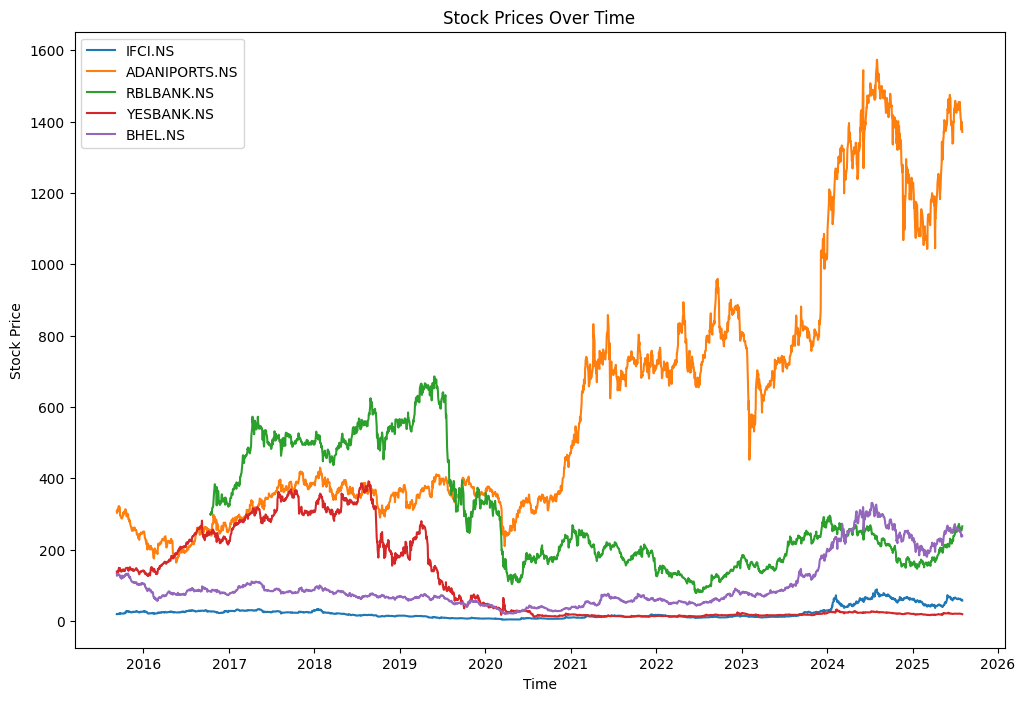

In [33]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

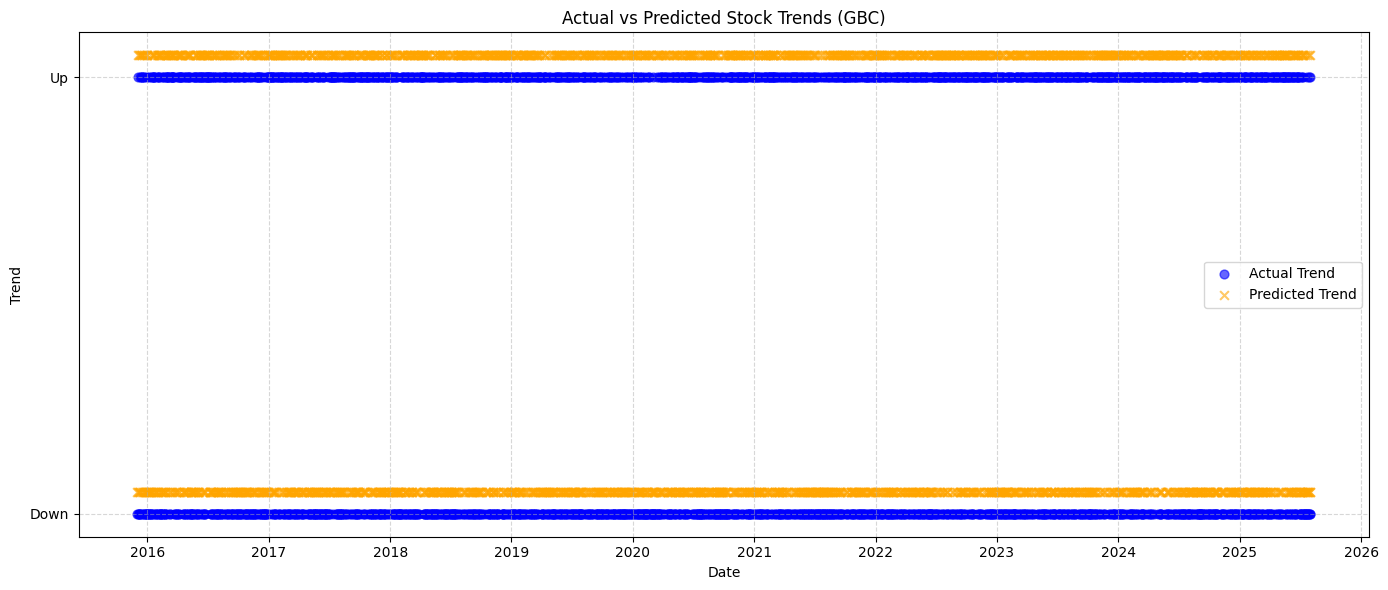

In [34]:
results_df = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': predictions_gb_hyp
})

plt.figure(figsize=(14, 6))

plt.scatter(results_df['Date'], results_df['Actual'], 
            label='Actual Trend', color='blue', alpha=0.6, s=40, marker='o')

jitter = 0.05
plt.scatter(results_df['Date'], results_df['Predicted'] + jitter,  
            label='Predicted Trend', color='orange', alpha=0.6, s=40, marker='x')

plt.yticks([0, 1], ['Down', 'Up'])
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title(f'Actual vs Predicted Stock Trends (GBC)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
#Using LSTM
def prepare_lstm_data(X, y, time_steps=10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:(i + time_steps)])
        y_lstm.append(y.iloc[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

In [36]:
def prepare_advanced_lstm_data(X, y, time_steps=7):
    X_lstm = []
    y_lstm = []
    
    if len(X) < time_steps + 1:
        return np.array([]), np.array([])
    
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps)].values
        target = y.iloc[i + time_steps]
        
        if not np.isnan(sequence).any() and not np.isnan(target):
            X_lstm.append(sequence)
            y_lstm.append(target)
    
    return np.array(X_lstm), np.array(y_lstm)

def create_lstm_features(X_base):
    X_lstm_features = X_base.copy()
    for col in ['RSI_14', 'MACD', 'Williams_R', 'Price_vs_SMA5']:
        if col in X_lstm_features.columns:
            # 3-day rolling mean for trend smoothing
            X_lstm_features[f'{col}_roll3'] = X_lstm_features[col].rolling(3, min_periods=1).mean()
            # 5-day rolling std for volatility patterns
            X_lstm_features[f'{col}_roll_std'] = X_lstm_features[col].rolling(5, min_periods=1).std().fillna(0)
    
    # Add momentum features (great for LSTM pattern recognition)
    if 'RSI_14' in X_lstm_features.columns:
        X_lstm_features['RSI_momentum'] = X_lstm_features['RSI_14'].diff(2).fillna(0)
    
    if 'MACD' in X_lstm_features.columns and 'MACD_Signal' in X_lstm_features.columns:
        X_lstm_features['MACD_momentum'] = (X_lstm_features['MACD'] - X_lstm_features['MACD_Signal']).diff().fillna(0)
    
    return X_lstm_features.fillna(0)

In [37]:
time_steps = 7
X_lstm, y_lstm = prepare_advanced_lstm_data(X_train, y_train, time_steps)
X_lstm_test, y_lstm_test = prepare_advanced_lstm_data(X_test, y_test, time_steps)

print(f"LSTM Training Data: {X_lstm.shape} sequences of {time_steps} days")
print(f"LSTM Test Data: {X_lstm_test.shape} sequences")
print(f"Feature count matches GBC/DNN: {X_lstm.shape[2]} features")

LSTM Training Data: (9549, 7, 27) sequences of 7 days
LSTM Test Data: (2382, 7, 27) sequences
Feature count matches GBC/DNN: 27 features


In [38]:
if len(X_lstm) == 0:
    lstm_model = None
else:
    lstm_model = Sequential([
        Input(shape=(time_steps, X_lstm.shape[2])),
        
        LSTM(64, activation='tanh', recurrent_activation='sigmoid', 
             return_sequences=False, dropout=0.2, recurrent_dropout=0.1),
        BatchNormalization(),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

In [39]:
if lstm_model is not None:
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    
    pos_samples = len(y_lstm[y_lstm == 1])
    neg_samples = len(y_lstm[y_lstm == 0])
    total_samples = len(y_lstm)
    pos_weight = total_samples / (2.0 * pos_samples)
    neg_weight = total_samples / (2.0 * neg_samples)
    class_weights_balanced = {0: neg_weight, 1: pos_weight}
    
    print(f"🔧 Class distribution: Positive={pos_samples} ({pos_samples/total_samples:.1%}), Negative={neg_samples} ({neg_samples/total_samples:.1%})")
    print(f"🔧 Simplified weights: Positive={pos_weight:.3f}, Negative={neg_weight:.3f}")
    
    lstm_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy', 
        patience=8, 
        restore_best_weights=True,
        verbose=1
    )

🔧 Class distribution: Positive=4543 (47.6%), Negative=5006 (52.4%)
🔧 Simplified weights: Positive=1.051, Negative=0.954


In [40]:
if lstm_model is not None and len(X_lstm) > 0:
    
    val_split_index = int(len(X_lstm) * 0.85)
    X_lstm_train = X_lstm[:val_split_index]
    y_lstm_train = y_lstm[:val_split_index] 
    X_lstm_val = X_lstm[val_split_index:]
    y_lstm_val = y_lstm[val_split_index:]
    
    print(f"📊 Training samples: {len(X_lstm_train)}")
    print(f"📊 Validation samples: {len(X_lstm_val)}")

    history_lstm = lstm_model.fit(
        X_lstm_train, y_lstm_train,
        validation_data=(X_lstm_val, y_lstm_val),
        epochs=20,
        batch_size=64,  
        class_weight=class_weights_balanced,
        callbacks=[early_stopping],
        verbose=1,
        shuffle=False
    )

📊 Training samples: 8116
📊 Validation samples: 1433
Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5146 - loss: 0.7779 - precision: 0.4699 - recall: 0.3741 - val_accuracy: 0.4515 - val_loss: 0.7033 - val_precision: 0.4212 - val_recall: 0.8173
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5175 - loss: 0.7018 - precision: 0.4817 - recall: 0.5309 - val_accuracy: 0.4389 - val_loss: 0.7209 - val_precision: 0.4250 - val_recall: 0.9502
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4954 - loss: 0.7002 - precision: 0.4619 - recall: 0.5184 - val_accuracy: 0.4361 - val_loss: 0.7112 - val_precision: 0.4213 - val_recall: 0.9153
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5258 - loss: 0.6909 - precision: 0.4905 - recall: 0.5611 - val_accuracy: 0.4341 - val_loss: 0.7154 - val_precision: 0.4228 - val_recall: 0.9502
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5182 - loss: 0.6929 - precision: 0.4843 

In [41]:
metrics = lstm_model.evaluate(X_lstm_test, y_lstm_test, verbose=0)
lstm_loss = metrics[0]
lstm_accuracy = metrics[1]
print(f"LSTM Model Loss: {metrics[0]:.4f}")
print(f"LSTM Model Accuracy: {metrics[1]:.4f}")

LSTM Model Loss: 0.7008
LSTM Model Accuracy: 0.4765


In [42]:
predictions_lstm = (lstm_model.predict(X_lstm_test) > 0.52).astype(int).flatten()
y_proba_lstm = lstm_model.predict(X_lstm_test).flatten()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_lstm_test, y_proba_lstm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8) 
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"🎯 Optimal threshold for balanced performance: {optimal_threshold:.3f}")

predictions_lstm_optimal = (y_proba_lstm > optimal_threshold).astype(int)

accuracy_lstm = accuracy_score(y_lstm_test, predictions_lstm)
f1_lstm = f1_score(y_lstm_test, predictions_lstm)
precision_lstm = precision_score(y_lstm_test, predictions_lstm)
recall_lstm = recall_score(y_lstm_test, predictions_lstm)
mse_lstm = mean_squared_error(y_lstm_test, y_proba_lstm)
mae_lstm = mean_absolute_error(y_lstm_test, y_proba_lstm)
auc_lstm = roc_auc_score(y_lstm_test, y_proba_lstm)
lloss_lstm = log_loss(y_lstm_test, y_proba_lstm)

# Also calculate metrics with optimal threshold
accuracy_lstm_opt = accuracy_score(y_lstm_test, predictions_lstm_optimal)
f1_lstm_opt = f1_score(y_lstm_test, predictions_lstm_optimal)
precision_lstm_opt = precision_score(y_lstm_test, predictions_lstm_optimal)
recall_lstm_opt = recall_score(y_lstm_test, predictions_lstm_optimal)

print(f"\nLSTM Model Evaluation (threshold=0.52):")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"F1 Score: {f1_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"MSE: {mse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"AUC-ROC: {auc_lstm:.4f}")
print(f"Log Loss: {lloss_lstm:.4f}")

print(f"\nLSTM Model Evaluation (optimal threshold={optimal_threshold:.3f}):")
print(f"Accuracy: {accuracy_lstm_opt:.4f}")
print(f"F1 Score: {f1_lstm_opt:.4f}")
print(f"Precision: {precision_lstm_opt:.4f}")
print(f"Recall: {recall_lstm_opt:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🎯 Optimal threshold for balanced performance: 0.425

LSTM Model Evaluation (threshold=0.52):
Accuracy: 0.4765
F1 Score: 0.5054
Precision: 0.4764
Recall: 0.5380
MSE: 0.2538
MAE: 0.5015
AUC-ROC: 0.4767
Log Loss: 0.7008

LSTM Model Evaluation (optimal threshold=0.425):
Accuracy: 0.4966
F1 Score: 0.6637
Precision: 0.4969
Recall: 0.9992


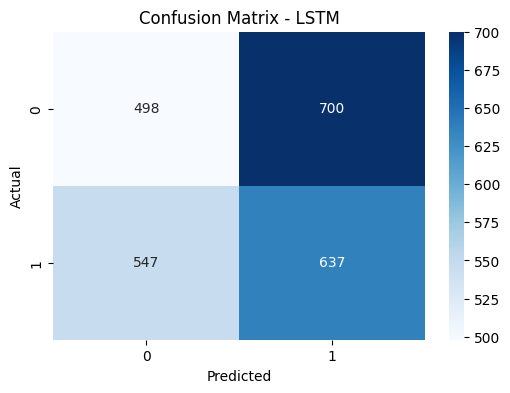

In [43]:
conf_matrix_lstm = confusion_matrix(y_lstm_test, predictions_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

In [44]:
def predict_trends_lstm_unified(data, model, scaler, time_steps=7):
    """
    🔧 UNIFIED LSTM PREDICTION: Uses same pipeline as GBC/DNN
    No more scaling mismatches or feature engineering differences
    """
    tomorrow_predictions = {}
    for ticker in tickers:
        if ticker in data:
            stock_data = data[ticker]
            if len(stock_data) >= time_steps + 5:
                try:
                    X_future_raw = stock_data[final_features].tail(time_steps + 5)
                    
                    if len(X_future_raw) >= time_steps and not X_future_raw.isnull().any().any():
                        X_future_scaled = scaler.transform(X_future_raw)
                        X_future_df = pd.DataFrame(X_future_scaled, columns=final_features)
                        
                        X_sequence = X_future_df.tail(time_steps).values
                        X_future_reshaped = X_sequence.reshape((1, time_steps, len(final_features)))
                        
                        print(f"Debug {ticker}: Input shape = {X_future_reshaped.shape} (unified pipeline)")
                        
                        prediction = model.predict(X_future_reshaped, verbose=0)[0][0]
                        tomorrow_predictions[ticker] = "Up" if prediction > 0.5 else "Down"
                    else:
                        tomorrow_predictions[ticker] = "Insufficient Clean Data"
                        
                except Exception as e:
                    print(f"Error predicting for {ticker}: {e}")
                    tomorrow_predictions[ticker] = "Error"
            else:
                tomorrow_predictions[ticker] = f"Need {time_steps + 5} days history"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions
              

In [45]:
trending_stocks_lstm = predict_trends_lstm_unified(all_data, lstm_model, scaler, time_steps=7)
print("Predicted Trending Stocks for Tomorrow (LSTM - Unified Pipeline):")
print(trending_stocks_lstm)

Debug IFCI.NS: Input shape = (1, 7, 27) (unified pipeline)
Debug ADANIPORTS.NS: Input shape = (1, 7, 27) (unified pipeline)
Debug RBLBANK.NS: Input shape = (1, 7, 27) (unified pipeline)
Debug YESBANK.NS: Input shape = (1, 7, 27) (unified pipeline)
Debug BHEL.NS: Input shape = (1, 7, 27) (unified pipeline)
Predicted Trending Stocks for Tomorrow (LSTM - Unified Pipeline):
{'IFCI.NS': 'Up', 'ADANIPORTS.NS': 'Up', 'RBLBANK.NS': 'Up', 'YESBANK.NS': 'Up', 'BHEL.NS': 'Up'}


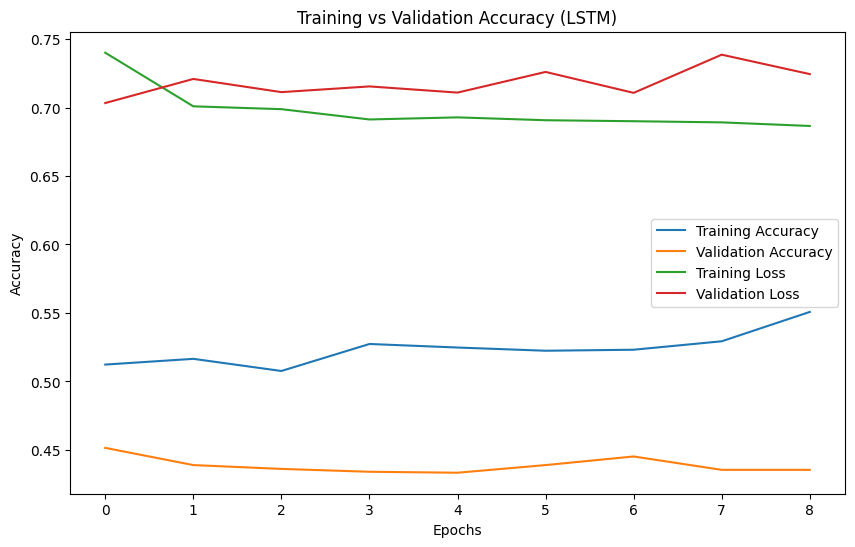

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (LSTM)')
plt.legend()
plt.show()

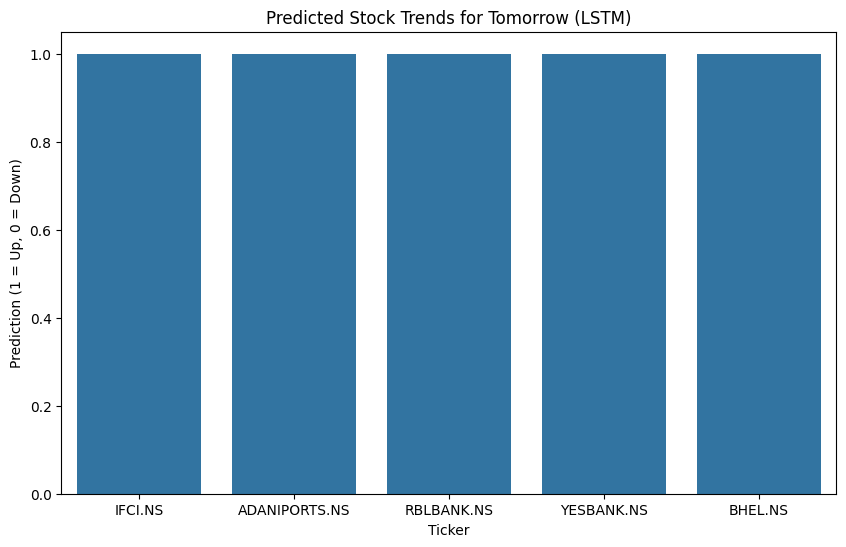

In [47]:
plt.figure(figsize=(10, 6))
trending_df_lstm = pd.DataFrame(
    [(k, v) for k, v in trending_stocks_lstm.items() if v in ['Up', 'Down']],
    columns=['Ticker', 'Prediction']
)
trending_df_lstm['Prediction'] = trending_df_lstm['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_lstm.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (LSTM)')
plt.show()

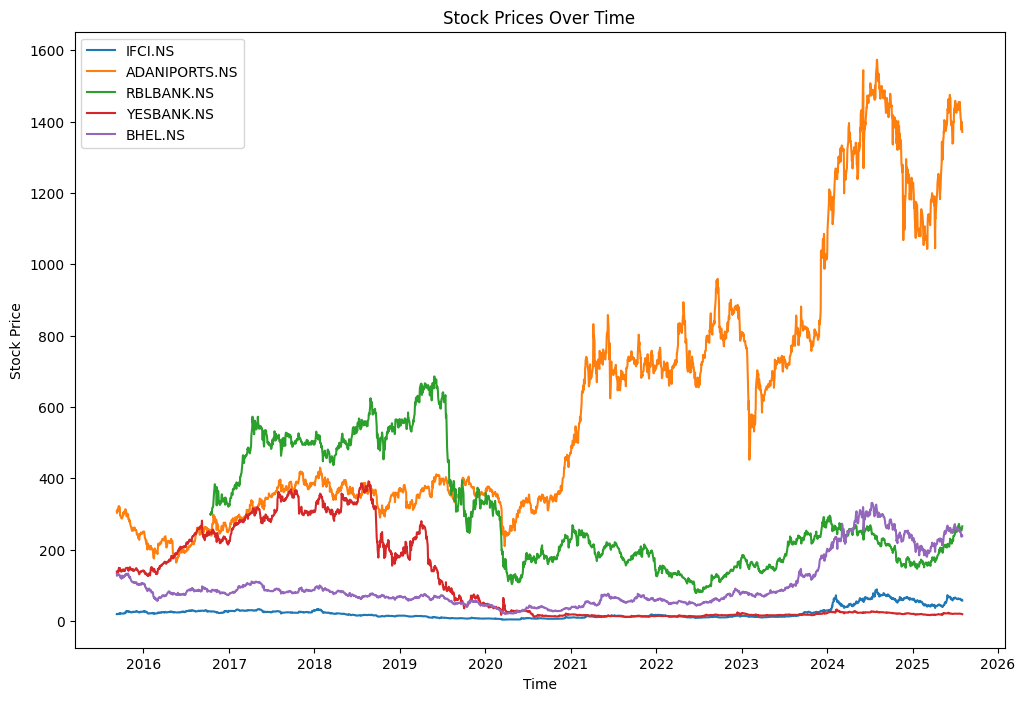

In [48]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

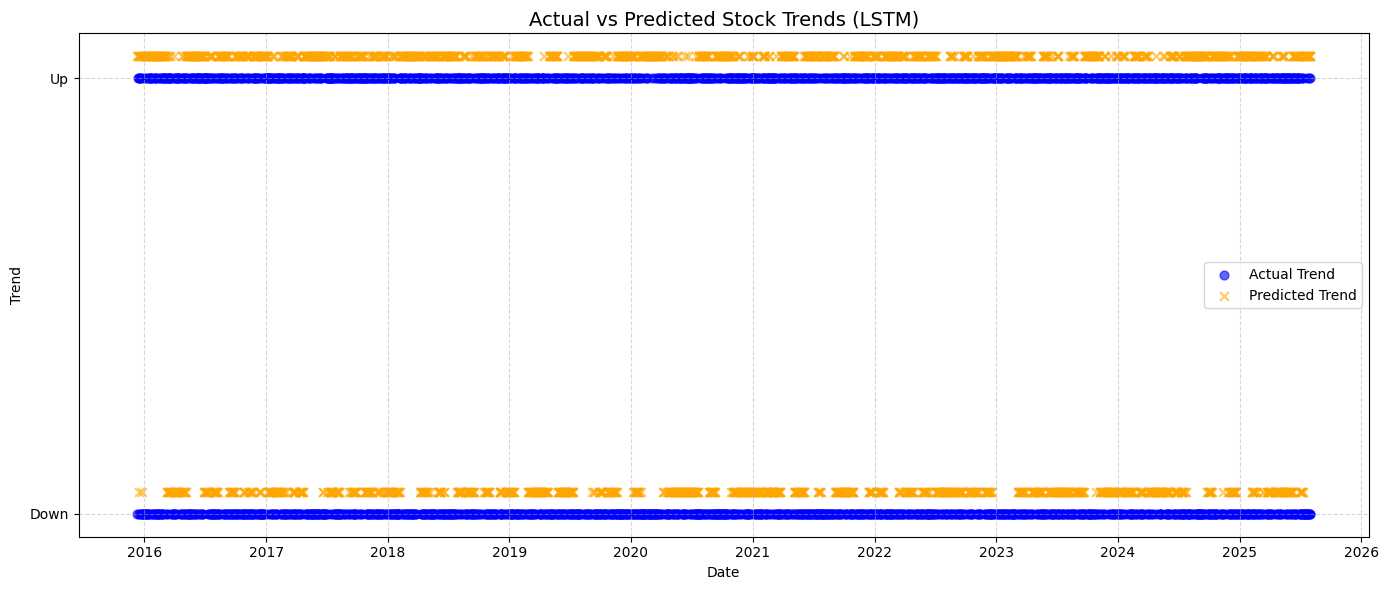

In [49]:
lstm_results_df = pd.DataFrame({
    'Date': X_test.index[time_steps:],
    'Actual': y_lstm_test,
    'Predicted': predictions_lstm
})

plt.figure(figsize=(14, 6))


plt.scatter(lstm_results_df['Date'], lstm_results_df['Actual'], 
            label='Actual Trend', color='blue', alpha=0.6, s=40, marker='o')

jitter = 0.05
plt.scatter(lstm_results_df['Date'], lstm_results_df['Predicted'] + jitter,  
            label='Predicted Trend', color='orange', alpha=0.6, s=40, marker='x')

plt.yticks([0, 1], ['Down', 'Up'])
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Actual vs Predicted Stock Trends (LSTM)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [50]:
#Dense Neural Network
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    BatchNormalization(),
    Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(1, activation='sigmoid')
])
dnn_model.compile(optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [52]:
pos_weight_dnn = len(y_train) / (2 * y_train.sum())
neg_weight_dnn = len(y_train) / (2 * (len(y_train) - y_train.sum()))
class_weights_dnn = {0: neg_weight_dnn, 1: pos_weight_dnn}

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history_dnn = dnn_model.fit(X_train, y_train,
                          validation_split=0.2,
                          epochs=50,
                          batch_size=64,
                          class_weight=class_weights_dnn,
                          callbacks=[early_stopping, reduce_lr],
                          verbose=1)

print(f"DNN trained with class weights: {class_weights_dnn}")

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5996 - loss: 0.9143 - precision_1: 0.5847 - recall_1: 0.6516 - val_accuracy: 0.7218 - val_loss: 0.7569 - val_precision_1: 0.6671 - val_recall_1: 0.6933 - learning_rate: 0.0010
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5996 - loss: 0.9143 - precision_1: 0.5847 - recall_1: 0.6516 - val_accuracy: 0.7218 - val_loss: 0.7569 - val_precision_1: 0.6671 - val_recall_1: 0.6933 - learning_rate: 0.0010
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7396 - loss: 0.7311 - precision_1: 0.7257 - recall_1: 0.7548 - val_accuracy: 0.7788 - val_loss: 0.6707 - val_precision_1: 0.7333 - val_recall_1: 0.7558 - learning_rate: 0.0010
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7396 - loss: 0.7311 - precision_1: 0.7257 - recall_1: 0.7548 - val_accuracy: 0.7788 - val_loss: 0.6707 - val_precision_1: 0.7333 - val_recall_1: 0.7558 - learning_rate: 0.0010
Epoch 3/50
120/120 ━━━━━━━━━━━━━

In [53]:
metrics = dnn_model.evaluate(X_test, y_test, verbose=0)
dnn_loss = metrics[0]
dnn_accuracy = metrics[1]
print(f"\nDNN Model Loss: {dnn_loss:.4f}")
print(f"DNN Model Accuracy: {dnn_accuracy:.4f}")


DNN Model Loss: 0.3587
DNN Model Accuracy: 0.8640


In [54]:
predictions_dnn = (dnn_model.predict(X_test) > 0.5).astype(int).flatten()
y_proba_dnn = dnn_model.predict(X_test).flatten()

accuracy_dnn = accuracy_score(y_test, predictions_dnn)
f1_dnn = f1_score(y_test, predictions_dnn)
precision_dnn = precision_score(y_test, predictions_dnn)
recall_dnn = recall_score(y_test, predictions_dnn)
mse_dnn = mean_squared_error(y_test, y_proba_dnn)
mae_dnn = mean_absolute_error(y_test, y_proba_dnn)
auc_dnn = roc_auc_score(y_test, y_proba_dnn)
lloss_dnn = log_loss(y_test, y_proba_dnn)

print(f"\nDNN Model Evaluation:")
print(f"Accuracy: {accuracy_dnn:.4f}")
print(f"F1 Score: {f1_dnn:.4f}")
print(f"Precision: {precision_dnn:.4f}")
print(f"Recall: {recall_dnn:.4f}")
print(f"MSE: {mse_dnn:.4f}")
print(f"MAE: {mae_dnn:.4f}")
print(f"AUC-ROC: {auc_dnn:.4f}")
print(f"Log Loss: {lloss_dnn:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

DNN Model Evaluation:
Accuracy: 0.8640
F1 Score: 0.8654
Precision: 0.8503
Recall: 0.8811
MSE: 0.0984
MAE: 0.2008
AUC-ROC: 0.9389
Log Loss: 0.3172

DNN Model Evaluation:
Accuracy: 0.8640
F1 Score: 0.8654
Precision: 0.8503
Recall: 0.8811
MSE: 0.0984
MAE: 0.2008
AUC-ROC: 0.9389
Log Loss: 0.3172


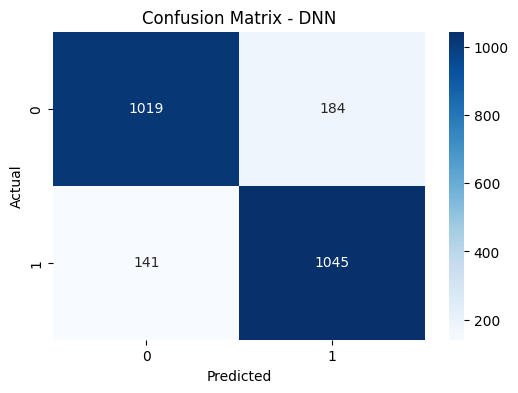

In [55]:
conf_matrix_dnn = confusion_matrix(y_test, predictions_dnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DNN')
plt.show()

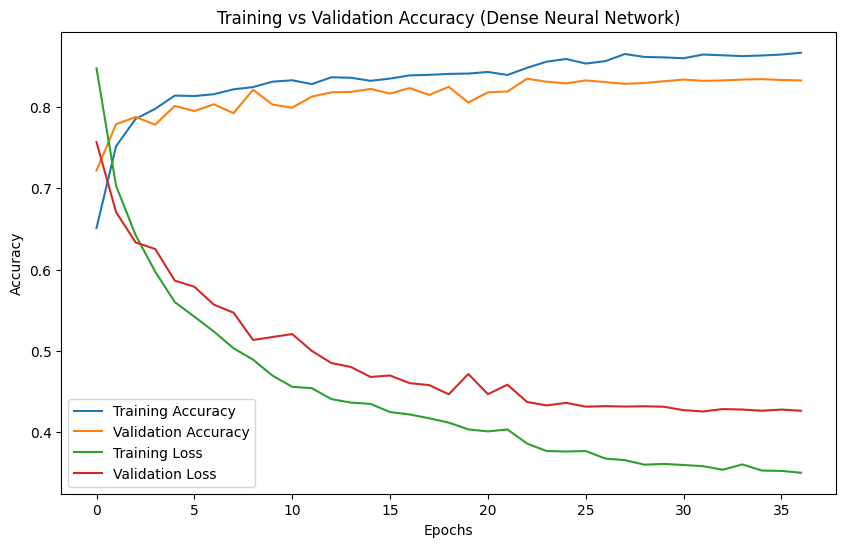

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Dense Neural Network)')
plt.legend()
plt.show()

In [57]:
def predict_trending_stocks_dnn(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        if ticker in data:
            stock_data = data[ticker]
            X_future = stock_data[final_features].tail(1)
            if not X_future.empty:
                X_future_scaled = scaler.transform(X_future)
                prediction = model.predict(X_future_scaled)[0]
                tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
            else:
                tomorrow_predictions[ticker] = "No Data"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [58]:
trending_stocks_dnn = predict_trending_stocks_dnn(all_data, dnn_model, scaler)
print("Trending Stocks for Tomorrow (Dense Neural Network):")
print(trending_stocks_dnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Trending Stocks for Tomorrow (Dense Neural Network):
{'IFCI.NS': 'Down', 'ADANIPORTS.NS': 'Down', 'RBLBANK.NS': 'Down', 'YESBANK.NS': 'Down', 'BHEL.NS': 'Down'}
Trending Stocks for Tomorrow (Dense Neural Network):
{'IFCI.NS': 'Down', 'ADANIPORTS.NS': 'Down', 'RBLBANK.NS': 'Down', 'YESBANK.NS': 'Down', 'BHEL.NS': 'Down'}


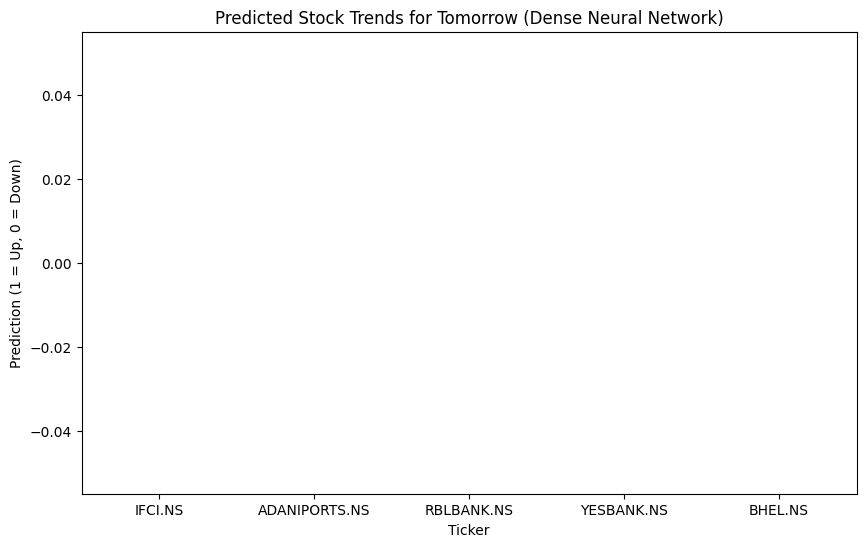

In [59]:
plt.figure(figsize=(10, 6))
trending_df_dnn = pd.DataFrame(list(trending_stocks_dnn.items()), columns=['Ticker', 'Prediction'])
trending_df_dnn['Prediction'] = trending_df_dnn['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_dnn.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Dense Neural Network)')
plt.show()

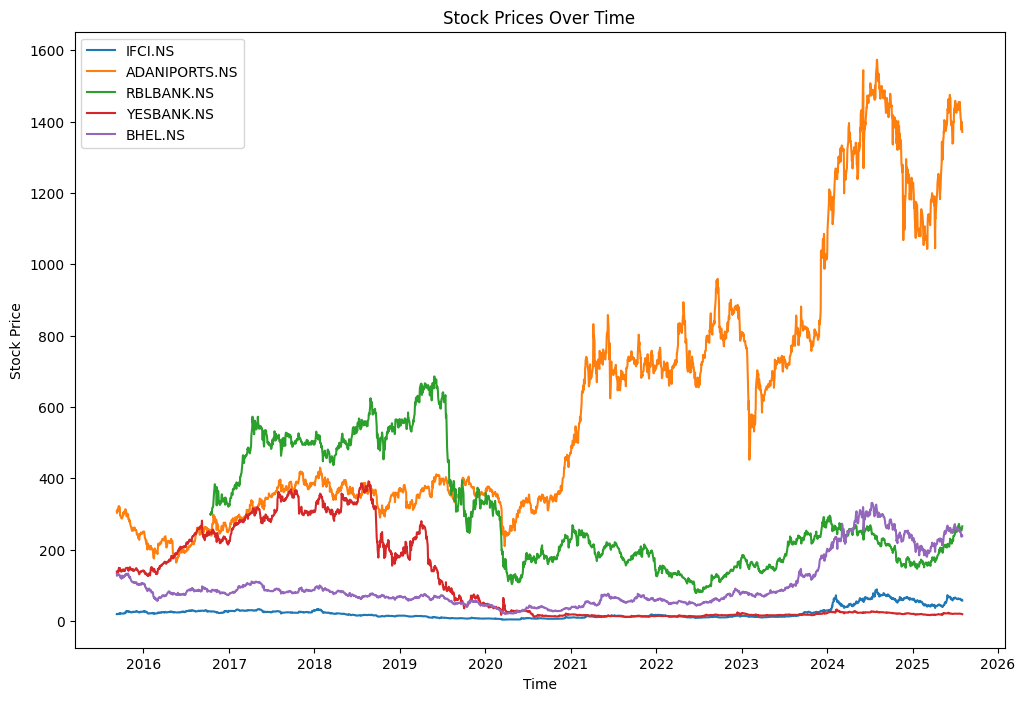

In [60]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

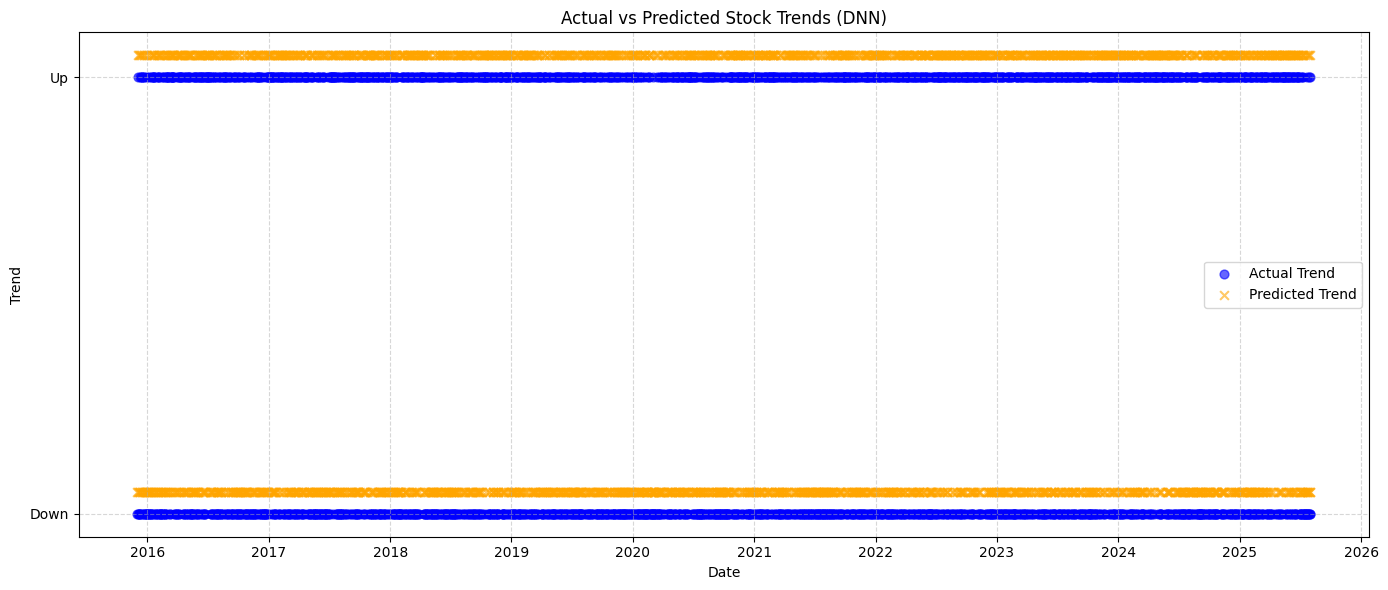

In [61]:
dnn_results_df = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': predictions_dnn
})

plt.figure(figsize=(14, 6))

plt.scatter(dnn_results_df['Date'], dnn_results_df['Actual'], 
            label='Actual Trend', color='blue', alpha=0.6, s=40, marker='o')

jitter = 0.05
plt.scatter(dnn_results_df['Date'], dnn_results_df['Predicted'] + jitter, 
            label='Predicted Trend', color='orange', alpha=0.6, s=40, marker='x')

plt.yticks([0, 1], ['Down', 'Up'])
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Actual vs Predicted Stock Trends (DNN)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


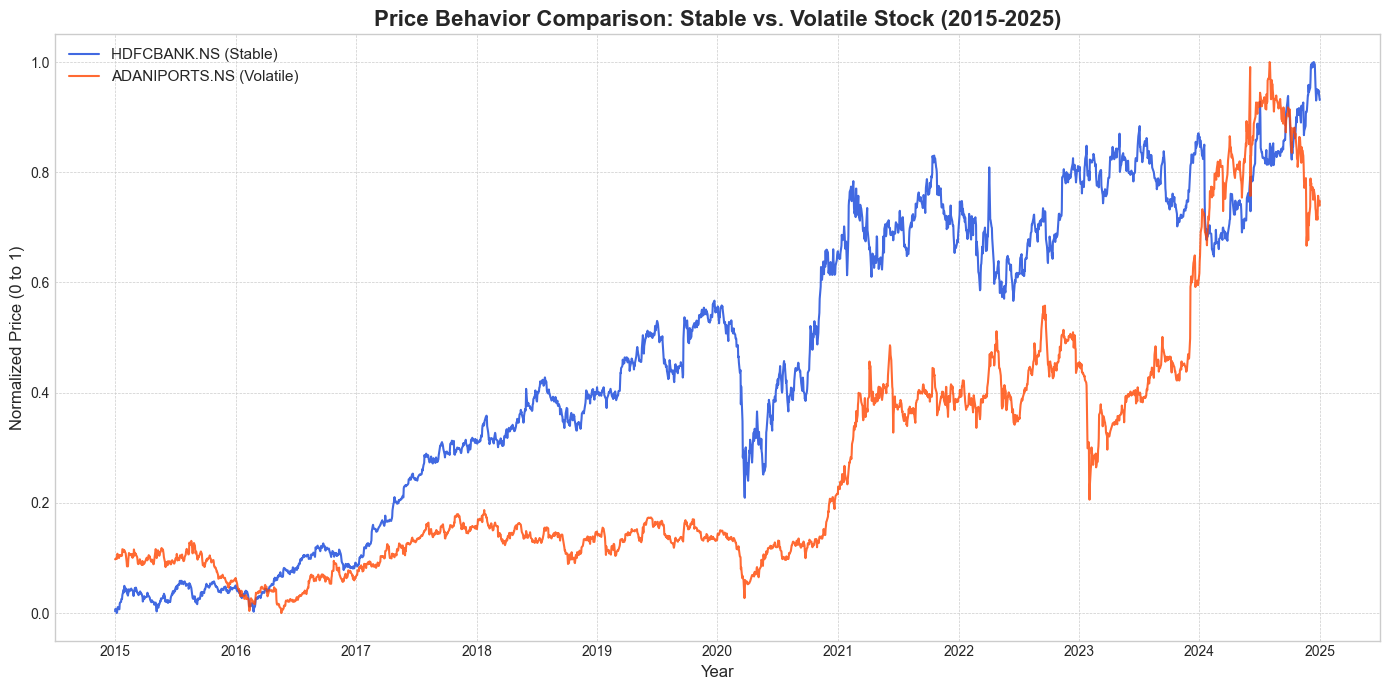

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. Setup: Define stocks and date range from the paper ---
stable_stock_ticker = 'HDFCBANK.NS'
volatile_stock_ticker = 'ADANIPORTS.NS'
start_date = '2015-01-01'
end_date = '2025-01-01'  # As per the 10-year span in the study [cite: 39]

# --- 2. Data Collection: Fetch data from Yahoo Finance ---
# This matches the data source mentioned in the paper [cite: 39]
try:
    stable_stock_data = yf.download(stable_stock_ticker, start=start_date, end=end_date)
    volatile_stock_data = yf.download(volatile_stock_ticker, start=start_date, end=end_date)

    if stable_stock_data.empty or volatile_stock_data.empty:
        raise ValueError("No data fetched. Please check stock tickers or your internet connection.")

    # --- 3. Preprocessing: Normalize the 'Close' prices for an accurate visual comparison ---
    scaler = MinMaxScaler()
    stable_stock_data['Normalized Price'] = scaler.fit_transform(stable_stock_data[['Close']])
    volatile_stock_data['Normalized Price'] = scaler.fit_transform(volatile_stock_data[['Close']])

    # --- 4. Visualization: Plot the data ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 7))

    plt.plot(stable_stock_data.index, stable_stock_data['Normalized Price'], label=f'{stable_stock_ticker} (Stable)', color='royalblue', linewidth=1.5)
    plt.plot(volatile_stock_data.index, volatile_stock_data['Normalized Price'], label=f'{volatile_stock_ticker} (Volatile)', color='orangered', alpha=0.8, linewidth=1.5)

    # --- 5. Formatting: Add title, labels, and legend for clarity ---
    plt.title('Price Behavior Comparison: Stable vs. Volatile Stock (2015-2025)', fontsize=16, weight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Normalized Price (0 to 1)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

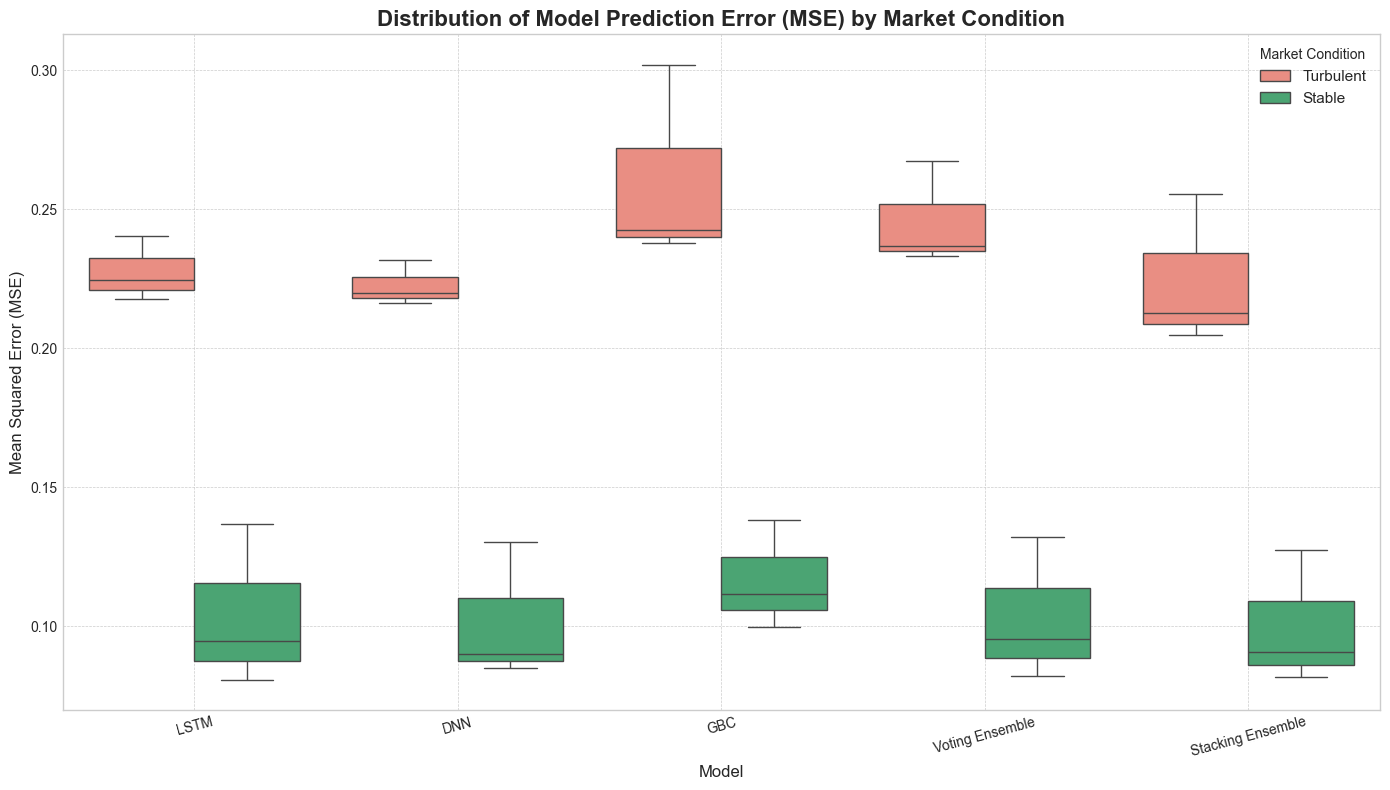

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Creation: A DataFrame is built using the precise MSE values from your paper's tables [cite: 97-109] ---
data = {
    'Model': [
        'LSTM', 'DNN', 'GBC', 'Voting Ensemble', 'Stacking Ensemble', # BHEL (Turbulent) [cite: 98]
        'LSTM', 'DNN', 'GBC', 'Voting Ensemble', 'Stacking Ensemble', # Adani Ports (Turbulent) [cite: 100]
        'LSTM', 'DNN', 'GBC', 'Voting Ensemble', 'Stacking Ensemble', # IFCI (Turbulent) [cite: 102]
        'LSTM', 'DNN', 'GBC', 'Voting Ensemble', 'Stacking Ensemble', # HDFC Bank (Stable) [cite: 105]
        'LSTM', 'DNN', 'GBC', 'Voting Ensemble', 'Stacking Ensemble', # Reliance (Stable) [cite: 107]
        'LSTM', 'DNN', 'GBC', 'Voting Ensemble', 'Stacking Ensemble', # Infosys (Stable) [cite: 109]
    ],
    'MSE': [
        0.2177, 0.2163, 0.2377, 0.2333, 0.2128, # BHEL MSEs [cite: 98]
        0.2245, 0.2198, 0.2425, 0.2367, 0.2047, # Adani Ports MSEs [cite: 100]
        0.2402, 0.2317, 0.3018, 0.2672, 0.2556, # IFCI MSEs [cite: 102]
        0.0945, 0.0901, 0.0998, 0.0820, 0.0817, # HDFC Bank MSEs [cite: 105]
        0.1368, 0.1304, 0.1383, 0.1321, 0.1273, # Reliance MSEs [cite: 107]
        0.0808, 0.0849, 0.1116, 0.0954, 0.0906, # Infosys MSEs [cite: 109]
    ],
    'Category':
        ['Turbulent'] * 15 + ['Stable'] * 15 # Categories as defined in the paper [cite: 112, 113]
}

df = pd.DataFrame(data)

# --- 2. Visualization: Create box plots using Seaborn ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

sns.boxplot(data=df, x='Model', y='MSE', hue='Category', palette={'Stable': 'mediumseagreen', 'Turbulent': 'salmon'})

# --- 3. Formatting: Add title, labels, and adjust layout for a professional look ---
plt.title('Distribution of Model Prediction Error (MSE) by Market Condition', fontsize=16, weight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Market Condition', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


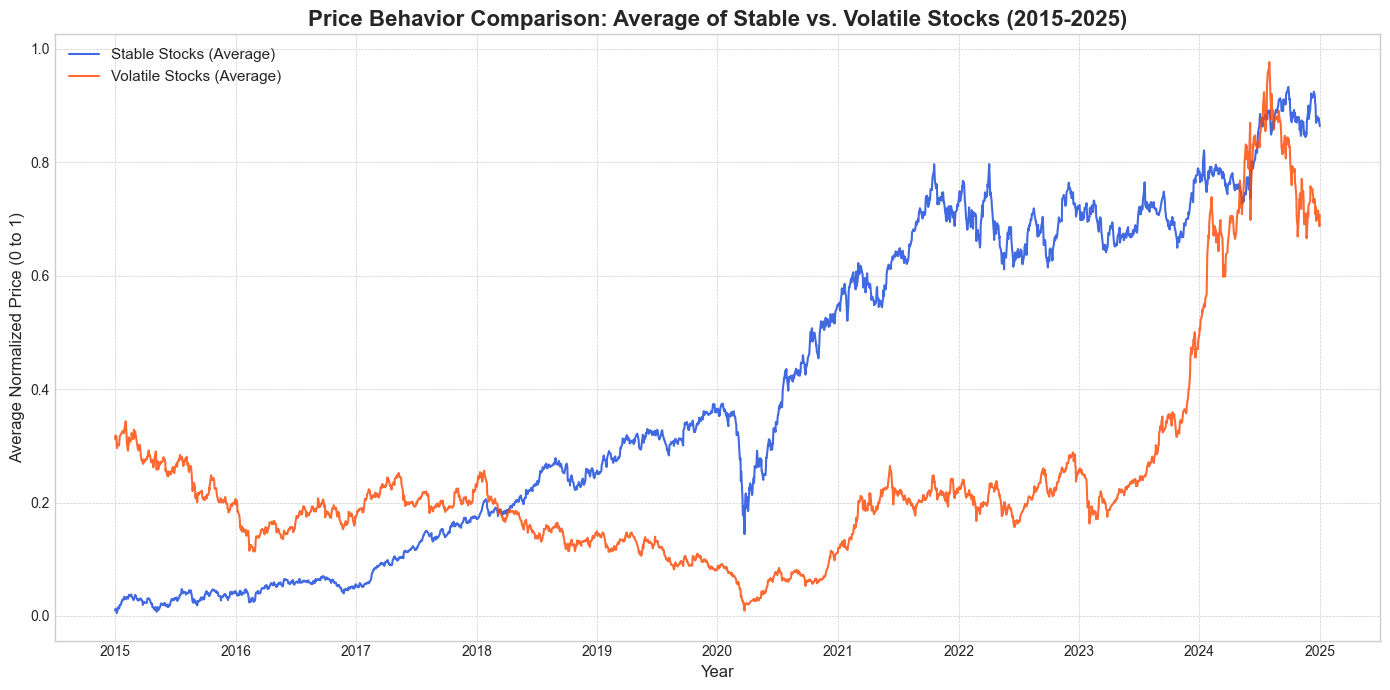

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. Setup: Define lists of stocks and date range ---
# [cite_start]Stock tickers and date range are based on your research paper's methodology [cite: 4, 16, 39]
stable_stock_tickers = ['HDFCBANK.NS', 'RELIANCE.NS', 'INFY.NS']
volatile_stock_tickers = ['ADANIPORTS.NS', 'IFCI.NS', 'BHEL.NS']
start_date = '2015-01-01'
end_date = '2025-01-01'

# --- 2. Data Collection: Fetch data from Yahoo Finance ---
try:
    stable_stock_data = yf.download(stable_stock_tickers, start=start_date, end=end_date)
    volatile_stock_data = yf.download(volatile_stock_tickers, start=start_date, end=end_date)

    if stable_stock_data.empty or volatile_stock_data.empty:
        raise ValueError("No data fetched. Please check stock tickers or your internet connection.")

    # --- 3. Preprocessing: Normalize prices and calculate the average for each category ---
    # Select only the 'Close' price columns, which have multi-level headers
    stable_close_prices = stable_stock_data['Close']
    volatile_close_prices = volatile_stock_data['Close']

    scaler = MinMaxScaler()

    # Normalize each stock's 'Close' price column individually
    normalized_stable_prices = pd.DataFrame(scaler.fit_transform(stable_close_prices),
                                            index=stable_close_prices.index,
                                            columns=stable_close_prices.columns)

    normalized_volatile_prices = pd.DataFrame(scaler.fit_transform(volatile_close_prices),
                                              index=volatile_close_prices.index,
                                              columns=volatile_close_prices.columns)

    # Calculate the average of the normalized prices to plot one representative line per category
    average_stable_price = normalized_stable_prices.mean(axis=1)
    average_volatile_price = normalized_volatile_prices.mean(axis=1)


    # --- 4. Visualization: Plot the average normalized prices ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 7))

    plt.plot(average_stable_price.index, average_stable_price, label='Stable Stocks (Average)', color='royalblue', linewidth=1.5)
    plt.plot(average_volatile_price.index, average_volatile_price, label='Volatile Stocks (Average)', color='orangered', alpha=0.8, linewidth=1.5)

    # --- 5. Formatting: Add title, labels, and legend for a clear, professional plot ---
    plt.title('Price Behavior Comparison: Average of Stable vs. Volatile Stocks (2015-2025)', fontsize=16, weight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Normalized Price (0 to 1)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")